# Analyzing long-term performance of the Keck-II adaptive optics system
By Emily Ramey

In [1]:
### Preamble
# Math and data processing
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.stats import sigma_clip
from astropy.time import Time
from math import sqrt, pi
from scipy.io import readsav
from importlib import reload
# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
# Self-defined
import process_data as pc
import plot_util as p_util
import data_util as d_util
import keck_data_compiler as comp
import run_ML as ml

In [2]:
# Data directories
data_dir = "../data/"
ao_root = '../ao_telemetry/'
telem_dir = "/g/lu/data/keck_telemetry/"
steve_file = data_dir+"lgs_metadata.fits"
my_file = data_dir+"combined_data/keck_AO_metadata.dat"
NAN_YEAR = 1858.876712328767

In [3]:
mpl.rcParams['font.size']=14
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)

In [4]:
### Uncomment if you want to reload the metadata file
# comp.update()

In [5]:
# weather_url = 'http://mkwc.ifa.hawaii.edu/current/seeing/'
# yr = "2010"
# url = weather_url + 'cfht-wx.' + yr + '.dat'
# try:
#     weather = pd.read_csv(url, delim_whitespace = True, header=None,
#                          usecols=range(n_weather_cols))
# except:
#     print(url)
# print(weather.columns)
# vprint('\tMessage: Downloaded data from '+url)

## Observations section

In [6]:
### Read in Steve's metadata file
file = Table.read(steve_file, format='fits')
steve_data = file.to_pandas()
steve_data.columns = [x.lower() for x in steve_data.columns]
year = Time(steve_data.mjd, format='mjd').decimalyear
steve_data['dec_year'] = year

### Read in my metadata file
# First sample: raw data
sample1 = pd.read_csv(my_file)
sample1.columns = [x.lower() for x in sample1.columns]
year = Time(sample1.mjd, format='mjd').decimalyear
sample1['dec_year'] = year
print("Sample 1:", sample1.shape)

# Second sample: invalid weather values removed
sample2 = pc.clean(sample1, delta_t_weather=5)
print("Sample 2:", sample2.shape)

# Third sample: invalid seeing and weather values removed
sample3 = pc.clean(sample2, delta_t_seeing=5)
print("Sample 3:", sample3.shape)

# Fourth sample: invalid telemetry values removed
sample4 = pc.clean(sample1, delta_t_telem=10)
print("Sample 4:", sample4.shape)

Sample 1: (5949, 46)
Sample 2: (5583, 47)
Sample 3: (2216, 48)
Sample 4: (1196, 47)


### Summary of data by observing night

In [7]:
data = sample1
epochs = np.unique(data.epoch)
categories = {
    'strehl': 2,
    'fwhm': 2,
    'mass': 2,
    'dimm': 2,
}
metric = np.nanmedian
aggregated = {cat:[] for cat in categories}
aggregated['days'] = []
# Compute metric on all categories for each epoch
for epoch in epochs:
    data_slice = data[data.epoch==epoch]
    data_mjds = np.unique(data_slice.mjd.astype(int))
    
    datestring = ''
    dts = Time(data_mjds, format='mjd').datetime
    datestring += dts[0].strftime("%Y %b ")
    for day in dts:
        d = day.strftime("%d, ")
        if day.day < 10:
            d = d[1:]
        datestring += d
    datestring = datestring[:-2]
    aggregated['days'].append(datestring)
    
    for cat, sigfigs in categories.items():
        ag = metric(data_slice[cat])
        ag = np.round(ag, sigfigs)
        aggregated[cat].append(ag)

df = pd.DataFrame()
df['days'] = aggregated['days']
for cat in categories:
    df[cat] = aggregated[cat]

d_util.setup("Observations", "general")
data_string = d_util.save_pandas(df, hlines=['top', 'mid', 'mid', 'bottom'], just=['l', 'r', 'r', 'r', 'r'],
                       filename="observation_nights.tex", save=False)

/opt/anaconda3/envs/astroconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


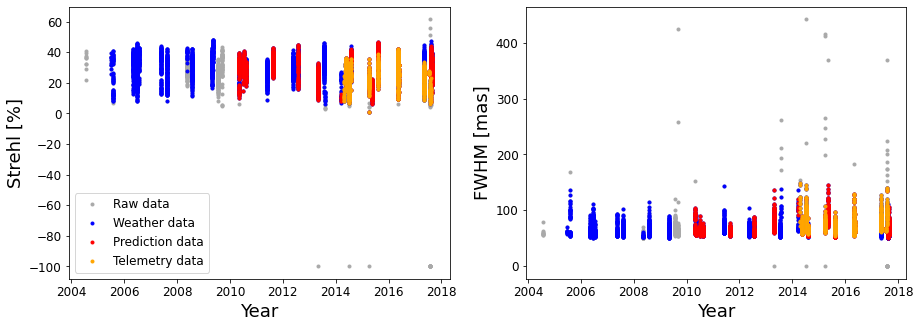

In [8]:
### Figure: image quality and seeing vs. date
### Which NIRC2 observations have weather, seeing, and telemetry data
p_util.setup("Observations", "weather")
fontsize = 18
colors = ['darkgray', 'blue', 'red', 'orange']
labels = ["Raw data", "Weather data", "Prediction data", "Telemetry data"]
samples = [sample1, sample2, sample3, sample4]

# Sort by # data points
zipped = zip(samples, labels)
sorted_zip = sorted(zipped, reverse=True, key = lambda x: x[0].shape[0])
tuples = zip(*sorted_zip)
samples, labels = [list(t) for t in tuples]

# Find NaN values
# no_seeing = data[np.isnan(data.mass_mjd)]

# Find decimal year
# all_dates = Time(data.mjd, format='mjd').decimalyear
# no_seeing_dates = Time(no_seeing.mjd, format='mjd').decimalyear

### Plot figure
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i,metric in enumerate(['strehl', 'fwhm']):
    for j,data in enumerate(samples):
        y = data[metric]*100 if metric=='strehl' else data[metric]
        ax[i].plot(data.dec_year, y, color=colors[j], marker='.', linestyle='None', label=labels[j])
    ax[i].set_xlabel("Year", fontsize=fontsize)
    ax[i].set_ylabel("FWHM [mas]" if metric=='fwhm' else "Strehl [%]",
                    fontsize=fontsize)

ax[0].legend(fontsize=12)
# p_util.savefig(fig, "qual_seeing_vs_date.png")
plt.show()

#### FWHM and Strehl plotted over time

In [9]:
### Sort data
data = sample2
labels = ['strehl', 'fwhm', 'aolbfwhm']
mj_days = np.unique(data.mjd.astype('int'))

# Separate data by day
data_by_day = {label:[
        data[label][data.mjd.astype(int)==day] 
        for day in mj_days
    ] for label in labels
}

means = {
    label: [np.mean(day) for day in days]
    for label, days in data_by_day.items()
}
medians = {
    label: [np.median(day) for day in days]
    for label, days in data_by_day.items()
}
std_devs = {
    label: [np.std(day)/np.sqrt(len(day)) for day in days]
    for label, days in data_by_day.items()
}
dec_year = Time(mj_days, format='mjd').decimalyear

Strehl: 0.28600000000000003 median, 0.07809209129113028 std
FWHM: 65.61250000000001 median, 13.81824535009983 std


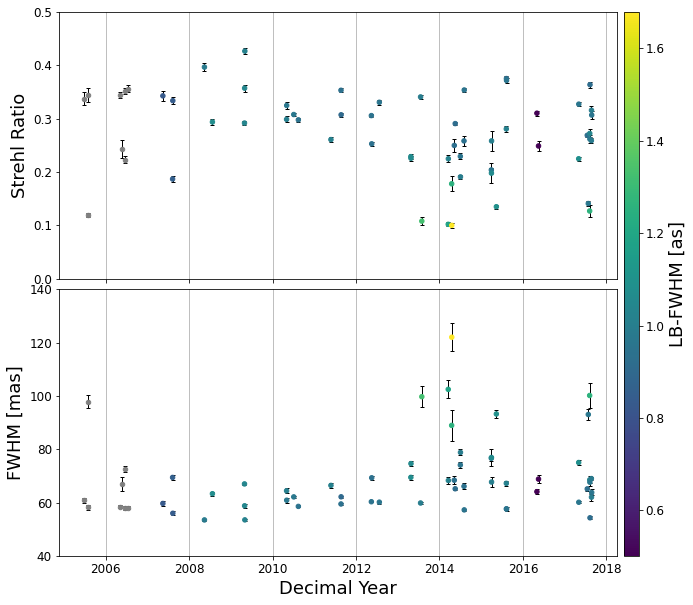

In [10]:
p_util.setup("Observations", 'nirc2')

box_plot = pd.DataFrame()
box_plot['dec_year'] = dec_year
box_plot['strehl'] = medians['strehl']
box_plot['fwhm'] = medians['fwhm']
box_plot['strehl_err'] = std_devs['strehl']
box_plot['fwhm_err'] = std_devs['fwhm']
box_plot['aolbfwhm'] = means['aolbfwhm']

strehl_med, strehl_std = np.median(box_plot['strehl']), np.std(box_plot['strehl'])
fwhm_med, fwhm_std = np.median(box_plot['fwhm']), np.std(box_plot['fwhm'])
print(f"Strehl: {strehl_med} median, {strehl_std} std")
print(f"FWHM: {fwhm_med} median, {fwhm_std} std")

p_util.plot_vars(box_plot, x_vars=['dec_year'], fontsize=18, y_vars=['strehl','fwhm'], y_err=['strehl_err', 'fwhm_err'],
                 c_var='aolbfwhm', fmt='box', figsize=(10,10), save=False, filename='img_quality_vs_time.png')

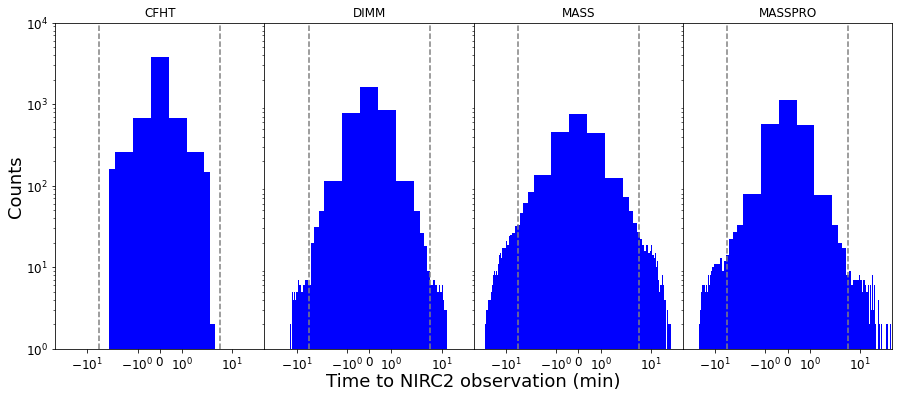

In [11]:
### Plot time interval between weather/seeing and image readings
data = sample1
p_util.setup("Observations", "combined")
fontsize=18

### Add columns
for obs_type in ['mass', 'dimm', 'masspro', 'cfht']:
    data[obs_type+'_delta_t'] = (data.mjd-data[obs_type+"_mjd"])*24*60 # delta t in minutes

dt_cols = ['cfht_delta_t', 'dimm_delta_t', 
           'mass_delta_t', 'masspro_delta_t']
dt_labels = ['CFHT', 'DIMM', 'MASS', 'MASSPRO']

xranges = (-10, 10)
yrange = (0, 1000)
nbins = 100

# r_right = np.logspace(-1, 2, 50)
# r_left = -r_right
# full_range = np.concatenate([r_left[::-1], r_right])
# print(full_range)
full_range = np.linspace(-1e2, 1e2, 250)

fig, ax = plt.subplots(1, 4, figsize=[15,6])
plt.subplots_adjust(wspace = 0)
# fig.text(0.5, 0.04, 'Minutes since observation', ha='center')

for i,col in enumerate(dt_cols):
    ax[i].hist(data[col], bins=full_range,
               label=dt_labels[i], color='b')
    ax[i].locator_params(axis='y', nbins=2)
    ax[i].set_title(dt_labels[i])
    
    ax[i].set_yscale('log')
    ax[i].set_xscale('symlog')
    ax[i].set_ylim([1, 1e4])
    ax[i].set_xlim([-10**1.8, 10**1.8])
    
    ax[i].axvline(5, ls='--', color='gray')
    ax[i].axvline(-5, ls='--', color='gray')
    
#     ax[i].set_ylim(yrange)
#     ax[i].set_yscale('log', nonposy='clip')
    if i!=0: ax[i].set_yticks([])
    
#     # TODO: take out hard-coded values
#     ax[i].set_xticks([-5,0, 5])
#     ax[i].set_xticklabels(['-5', '0', '+5'])

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel("Time to NIRC2 observation (min)", fontsize=fontsize)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.set_ylabel("Counts", fontsize=fontsize)

# p_util.savefig(fig, "time_since_obs.png")
plt.show()

## Methods Section
### Weather Analysis

In [12]:
save = False

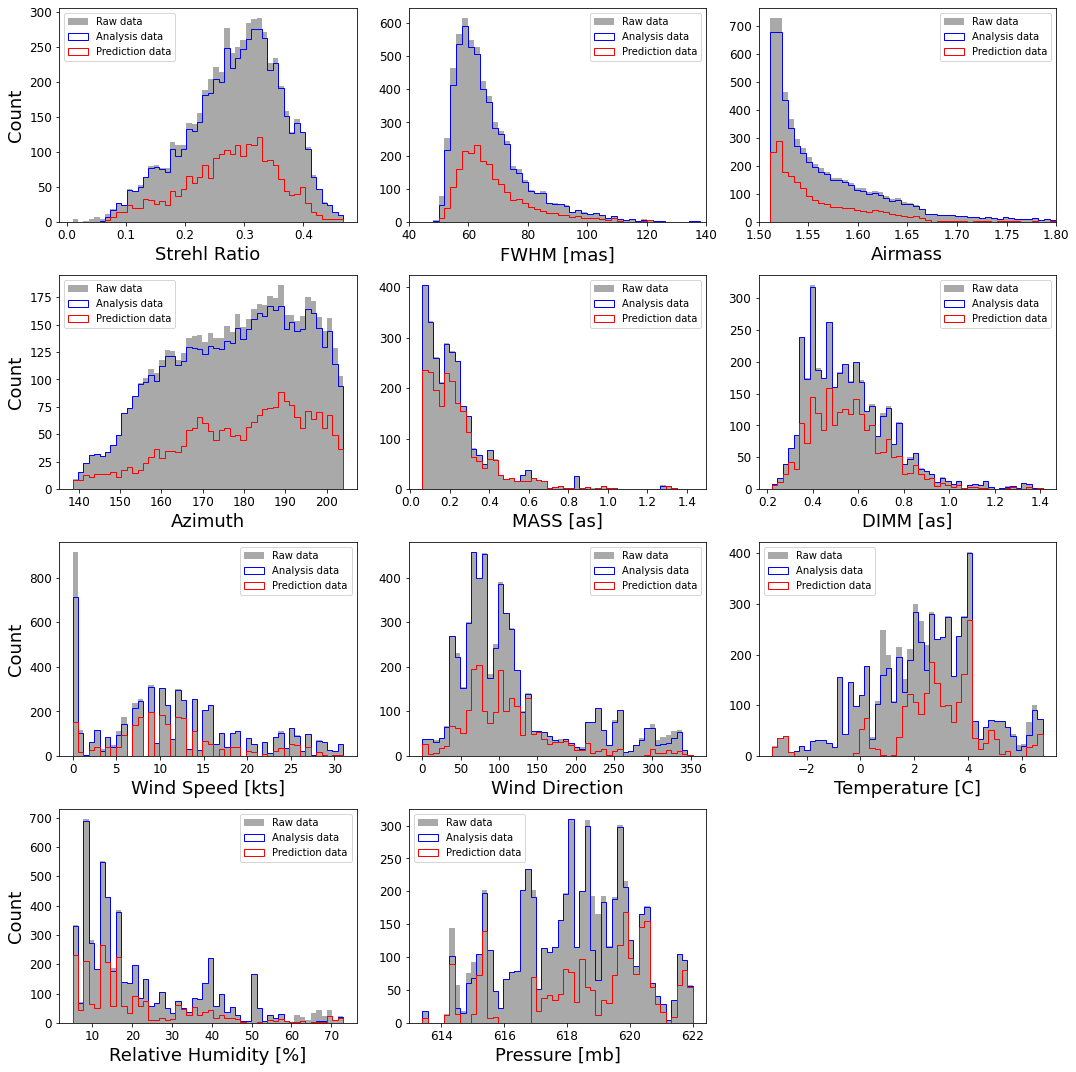

In [13]:
### Graph the features to see what values they take on
p_util.setup("Observations", "weather")
not_clean = pc.read_file("keck_metadata.dat")
ML_clean = pc.read_file("keck_clean_woNA.dat")
weather_clean = pc.read_file("keck_clean_wNA.dat")

not_clean = sample1
ML_clean = sample3
weather_clean = sample2

bins = 50
fontsize=18

params = {
    'fwhm': [40, 140],
    'airmass': [1.5, 1.8],
}
settings = p_util.default_settings

num_rows = 4
num_cols = 3
fig, axes = plt.subplots(4, 3, figsize=[15, 15])

for i, ax in enumerate(axes.flatten()):
    if i >= len(pc.use_cols):
        ax.axis('off')
        continue
    
    col = pc.use_cols[i]
    xrange = None if col not in params else params[col]
    _, bin_edges, h3 = ax.hist(ML_clean[col], bins, range=xrange, histtype='step', color='red', label="Prediction data", zorder=10)
    
    # Clean histogram
    _, _, h1 = ax.hist(not_clean[col], bins=bin_edges, label="Raw data", color='darkgray', zorder=0)
    _, _, h2 = ax.hist(weather_clean[col], bins=bin_edges, histtype='step', color='blue', label="Analysis data", zorder=5)
    
    xlabel = col if col not in settings['label'] else settings['label'][col]
    ax.set_xlabel(xlabel, fontsize=fontsize)
    
    if col in params: # has xlimits
        ax.set_xlim(params[col])
    if i%num_cols==0: # not left edge
        ax.set_ylabel("Count", fontsize=fontsize)
    hh = [h1[0], h2[0], h3[0]]
    ax.legend(hh, [h.get_label() for h in hh], loc='best')
    
plt.tight_layout()
# p_util.savefig(fig, "data_hists.png")
plt.show()

##### Data-on-data weather & seeing plots

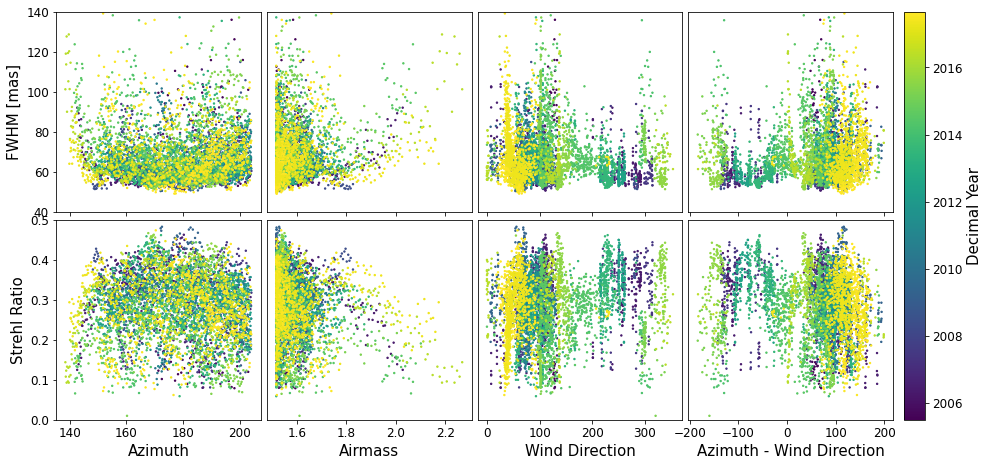

In [14]:
### First data-on-data plot:
### Azimuth, Airmass, Wind Direction, Azimuth - Wind Direction vs. image quality
data = sample2
p_util.setup("Methods", "weather")

# Save settings
settings = p_util.default_settings.copy()
settings['label'].update({'az-wdir':'Azimuth - Wind Direction'})
data['az-wdir'] = data['az']-data['wind_direction']
# Plot
x_vars = ['az', 'airmass', 'wind_direction', 'az-wdir']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='dec_year', fontsize=15, settings=settings, save=save)

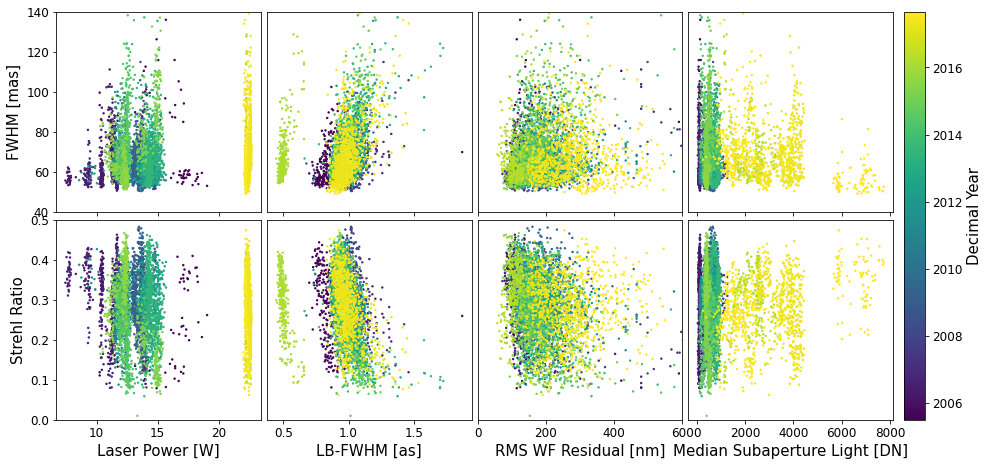

In [15]:
### Second data-on-data plot:
### AOAOMED, LSAMPPWR, AOLBFWHM, LGRMSWF vs. strehl and fwhm
data = sample2
p_util.setup("Methods", 'weather')

x_vars = ['lsamppwr', 'aolbfwhm', 'lgrmswf', 'aoaoamed']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='dec_year', fontsize=15, save=save)

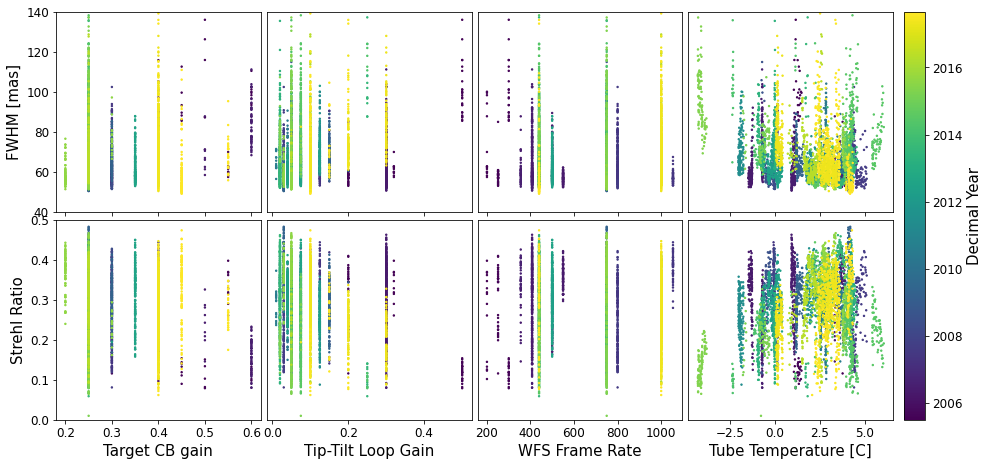

In [16]:
### Third data-on-data plot:
### tubetemp, dmgain, dtgain, and wsfrrt
data = sample2
p_util.setup("Methods", 'weather')

# Save settings
# settings = p_util.default_settings.copy()
# settings['label'].update({'ttemp-temp':'Tube temp. - Temp [C]'})
# data['ttemp-temp'] = data['tubetemp']-data['temperature']
# Plot
x_vars = ['dmgain', 'dtgain', 'wsfrrt', 'tubetemp']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='dec_year', fontsize=15, settings=settings, save=save)

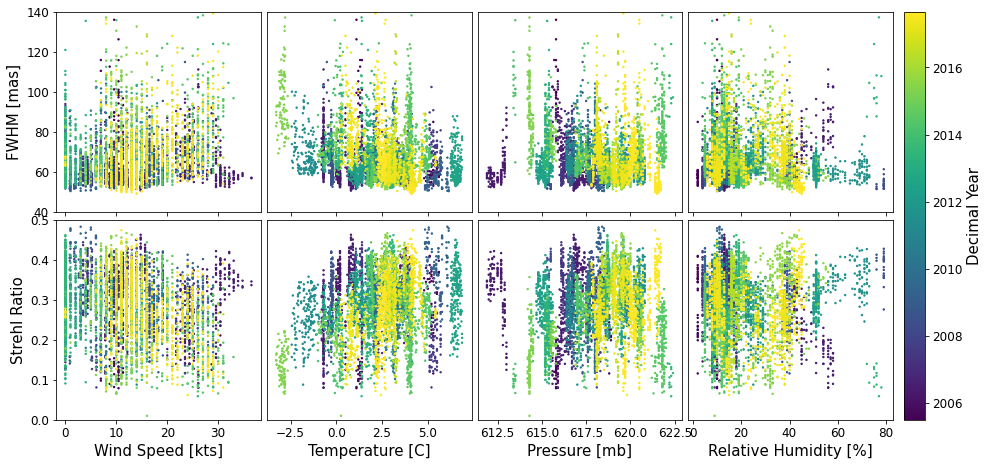

In [17]:
### Fourth data-on-data plot
### wind_speed, temperature, pressure, and relative_humidity
data = sample2
p_util.setup("Methods", 'weather')

x_vars = ['wind_speed', 'temperature', 'pressure', 'relative_humidity']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='dec_year', fontsize=15, save=save)

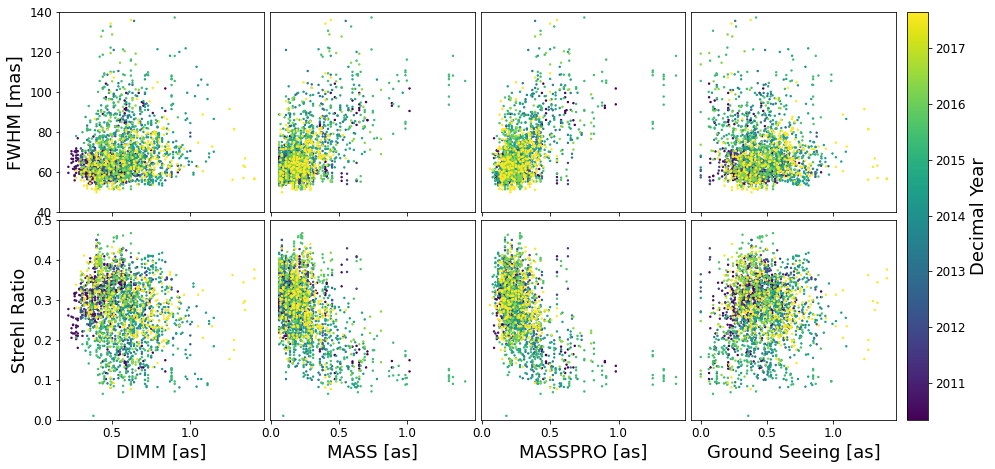

In [18]:
### Fifth data-on-data plot:
### Seeing variables
data = sample3
p_util.setup("Methods", 'weather')

# Save settings
settings = p_util.default_settings.copy()
settings['label'].update({'low-alt-seeing':'Ground Seeing [as]'})
data['low-alt-seeing'] = np.power(np.abs(data.dimm**(5/3.0) - data.mass**(5/3.0)), 3/5.0)
# Plots
x_vars = ['dimm', 'mass', 'masspro', 'low-alt-seeing']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='dec_year', settings=settings, fontsize=18, save=save)

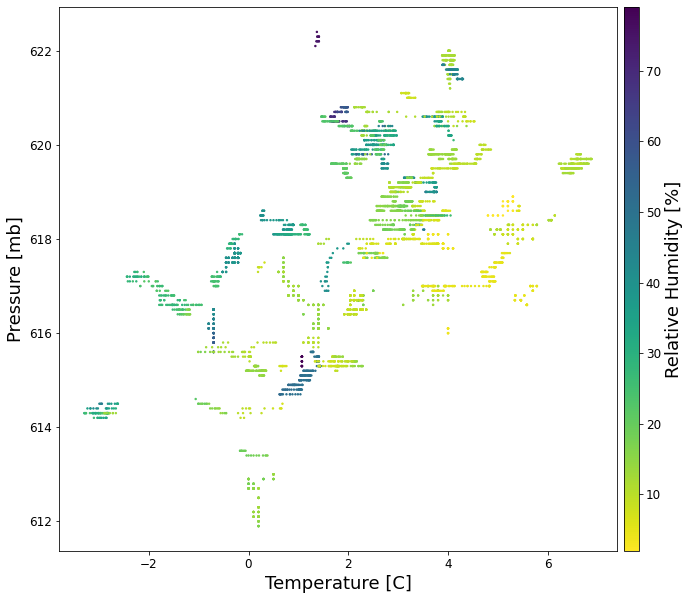

In [19]:
### Sixth data-on-data plot:
### Pressure-v-Temperature
data = sample2
p_util.setup("Methods", 'weather')

x_vars = ['temperature']
y_vars = ['pressure']
p_util.plot_vars(data, x_vars, y_vars, c_var='relative_humidity', fontsize=18, figsize=(10, 10), 
                 cmap='viridis_r', save=save)

### Telemetry Analysis

In [20]:
# Read in test file
testfile1 = "/g/lu/data/keck_telemetry/20170718/sdata901/nirc15/2017jul18/n0098_LGS_trs.sav"
testfile2 = "/g/lu/data/keck_telemetry/20150401/sdata904/nirc9/2015apr01_C/n1015_fullLGS_trs.sav"

In [21]:
data = readsav(testfile1)
data.a.dtype.fields

mappingproxy({'CONF_ID': (dtype('O'), 0, 'conf_id'),
              'conf_id': (dtype('O'), 0, 'conf_id'),
              'TIMESTAMP': (dtype('O'), 8, 'timestamp'),
              'timestamp': (dtype('O'), 8, 'timestamp'),
              'SUBAPINTENSITY': (dtype('O'), 16, 'subapintensity'),
              'subapintensity': (dtype('O'), 16, 'subapintensity'),
              'OFFSETCENTROID': (dtype('O'), 24, 'offsetcentroid'),
              'offsetcentroid': (dtype('O'), 24, 'offsetcentroid'),
              'RESIDUALWAVEFRONT': (dtype('O'), 32, 'residualwavefront'),
              'residualwavefront': (dtype('O'), 32, 'residualwavefront'),
              'DMCOMMAND': (dtype('O'), 40, 'dmcommand'),
              'dmcommand': (dtype('O'), 40, 'dmcommand'),
              'DMCOMMANDSCLIPPED': (dtype('O'), 48, 'dmcommandsclipped'),
              'dmcommandsclipped': (dtype('O'), 48, 'dmcommandsclipped'),
              'RESIDUALRMS': (dtype('O'), 56, 'residualrms'),
              'residualrms': (dtyp

In [22]:
timestamps = data.a.timestamp[0]
intervals = timestamps[1:]-timestamps[:-1]
print(f"range: {(timestamps[-1]-timestamps[0])/1e7}")
np.mean(intervals/1e7)

range: 19.0777528


0.0010003540873577685

##### Offset Centroids vs. time

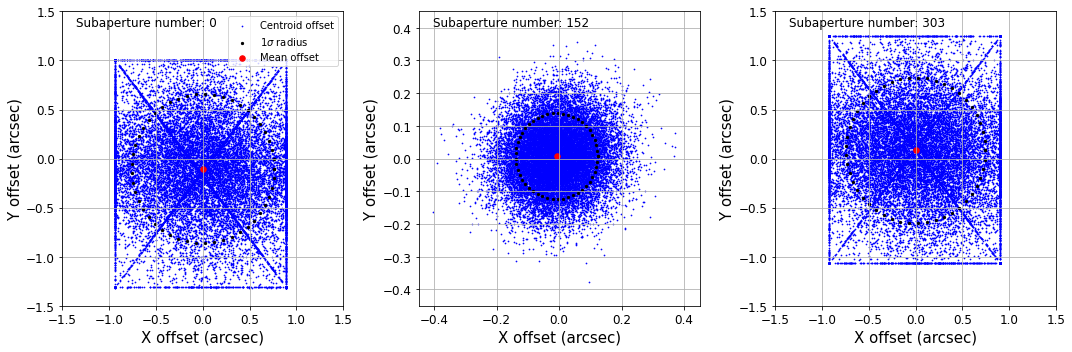

In [23]:
### Plot offset-centroids for three lenslets
p_util.setup("Methods", 'telemetry')
fonts = {
    'labels':15,
    'legend':10,
    }
p_util.plot_lenslets(testfile1, [0, 152, 303], shape=(1,3), xlim={152:(-.45,.45)}, fontsize=fonts, save=False)

##### Plot lenslet arrays

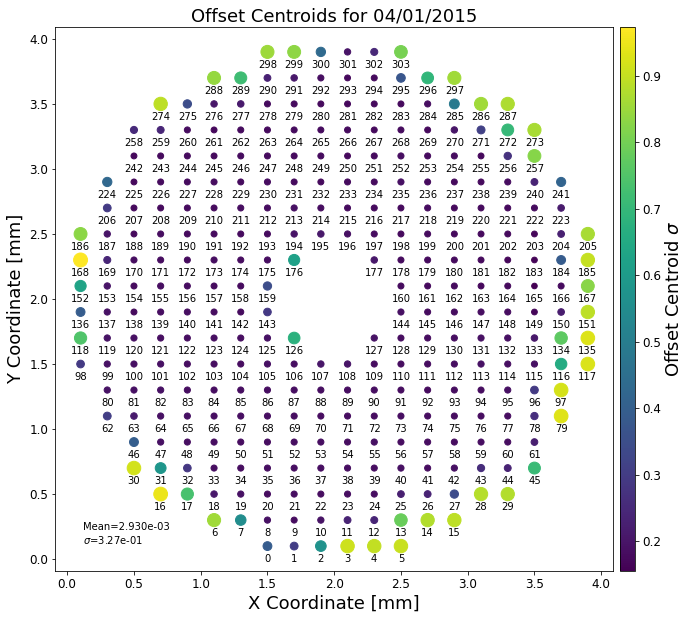

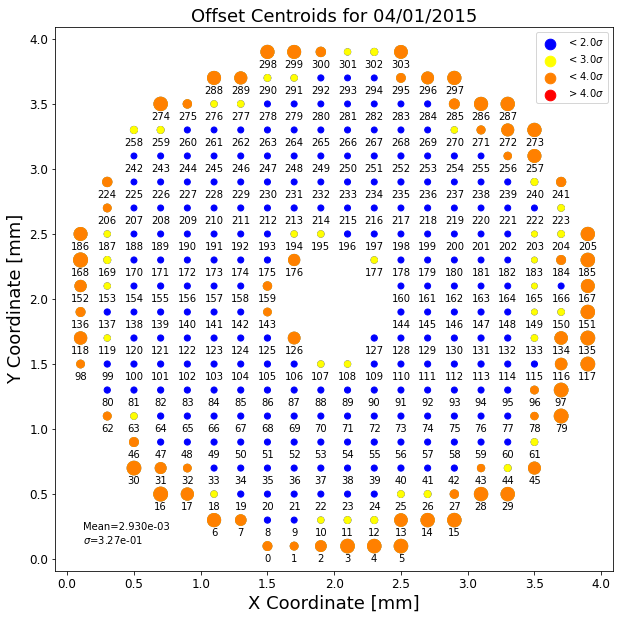

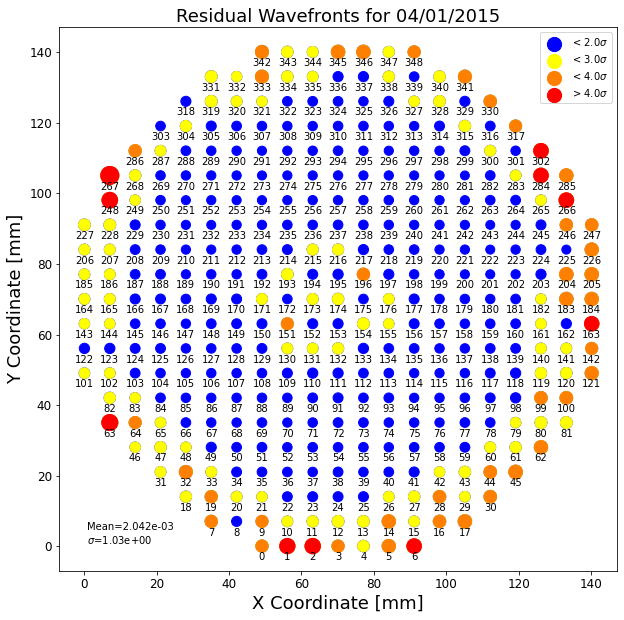

In [24]:
### Three lenslet arrays
p_util.setup("Methods", 'telemetry')
save = False
file = testfile2

p_util.plot_array(file, save=save)
p_util.plot_array(file, sig_clip=[2.0, 3.0, 4.0], save=save)
p_util.plot_array(file, data_type='residual wavefront', sig_clip=[2.0, 3.0, 4.0], 
                  map_file='../ao_telemetry/act.txt', save=save)

### PCA
Explained variance ratio

Text(0, 0.5, 'Explained Variance [%]')

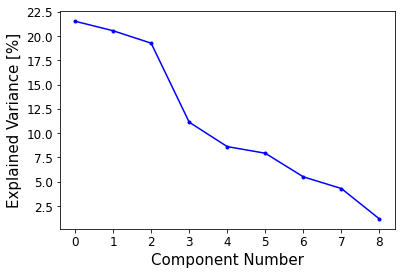

In [25]:
p_util.setup("Methods", "ML")
pca_meta = pc.read_file("keck_pca_metadata.dat")
fontsize = 15

fig, ax = plt.subplots()
ax.plot(pca_meta.explained_variance_ratio*100, '.-', color='b')
ax.set_xlabel("Component Number", fontsize=fontsize)
ax.set_ylabel("Explained Variance [%]", fontsize=fontsize)

# p_util.savefig(fig, "pca_explained_var.png")

Text(0, 0.5, 'Weight [%]')

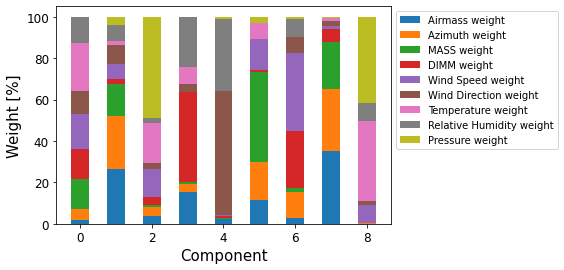

In [26]:
### Plot makeup of principal components
p_util.setup("Methods", "ML")
fontsize = 15

n_comp = len(pca_meta)
xcols = [x+"_weight" for x in pc.X_cols]
label_params = p_util.default_settings['label']
labels = [label_params[x].split('[')[0].strip()+" weight" for x in pc.X_cols]

x = np.arange(0, n_comp)
colors = plt.cm.get_cmap('viridis', n_comp)

fig, ax = plt.subplots()

prev_bar = np.zeros(n_comp)
for i,col in enumerate(xcols):
    component = pca_meta[col]
    c = (component**2)*100
    ax.bar(x, c, width=0.5, bottom=prev_bar, label=labels[i])
    prev_bar += c

lgd = ax.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Component", fontsize=fontsize)
plt.ylabel("Weight [%]", fontsize=fontsize)
# p_util.savefig(fig, "pca_components.png")

# Results Section

#### Telemetry Correlations

In [5]:
### Set up for telemetry correlation
# usecols = ['mjd', 'lgrmswf', 'rms_err', 'rms_mean', 'rms_std', 'strehl', 'fwhm']
# colnames = ['mjd', 'lgrmswf', 'rms_err', 'residual_rms', 'residual_rms_std', 'strehl', 'fwhm']

data = sample4
data = data.rename(columns={"rms_mean": "residual_rms", "rms_std": "residual_rms_std"})
data

,index,file,strehl,rms_err,fwhm,mjd,epoch,airmass,itime,coadds,...,masspro_4,masspro_8,masspro_16,masspro,wind_speed,wind_direction,temperature,relative_humidity,pressure,dec_year
0,3557,c0034.fits,0.203,427.2,79.14,56765.60473,14aprlgs,1.51726,2.8,10,...,NaN,NaN,NaN,NaN,29.0,102.0,2.70,4.0,617.7,2014.294807
1,3558,c0036.fits,0.243,402.0,70.93,56765.60627,14aprlgs,1.51805,2.8,10,...,NaN,NaN,NaN,NaN,30.0,102.0,2.69,4.0,617.7,2014.294812
2,3559,c0038.fits,0.155,461.9,97.38,56765.60779,14aprlgs,1.51901,2.8,10,...,NaN,NaN,NaN,NaN,30.0,129.0,2.63,4.0,617.7,2014.294816
3,3560,c0040.fits,0.212,421.3,78.61,56765.60933,14aprlgs,1.52017,2.8,10,...,NaN,NaN,NaN,NaN,29.0,106.0,2.58,4.0,617.6,2014.294820
4,3561,c0042.fits,0.134,479.4,104.60,56765.61089,14aprlgs,1.52151,2.8,10,...,NaN,NaN,NaN,NaN,28.0,114.0,2.47,4.0,617.6,2014.294824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,5684,c0234.fits,0.255,395.1,71.76,57877.61035,17maylgs1,1.64154,2.8,10,...,NaN,NaN,NaN,NaN,16.0,40.0,1.07,27.0,618.3,2017.338658
1192,5685,c0235.fits,0.307,367.5,65.22,57877.61094,17maylgs1,1.64437,2.8,10,...,NaN,NaN,NaN,NaN,16.0,42.0,1.06,26.0,618.3,2017.338660
1193,5686,c0236.fits,0.287,377.9,65.62,57877.61153,17maylgs1,1.64725,2.8,10,...,NaN,NaN,NaN,NaN,16.0,37.0,1.05,26.0,618.3,2017.338662
1194,5687,c0237.fits,0.279,382.2,67.46,57877.61212,17maylgs1,1.65016,2.8,10,...,NaN,NaN,NaN,NaN,16.0,37.0,1.05,26.0,618.3,2017.338663


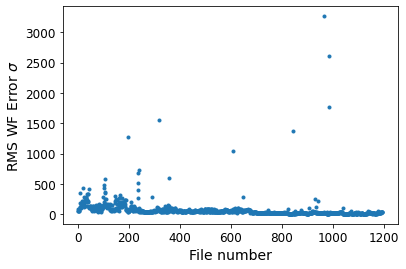

In [7]:
# plt.plot(data.residual_rms, '.')
plt.plot(data.residual_rms_std, '.')
plt.xlabel("File number")
plt.ylabel("RMS WF Error $\sigma$")
plt.show()

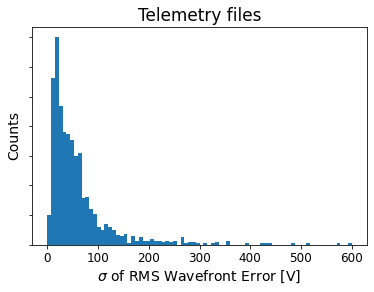

In [8]:
fig, ax = plt.subplots()
ax.hist(data.residual_rms_std, bins=80, range=(0, 600), log=False)
ax.set_xlabel("$\sigma$ of RMS Wavefront Error [V]")
ax.set_ylabel("Counts")
ax.set_title("Telemetry files")
ax.set_yticklabels([])
plt.show()

/g/lu/data/keck_telemetry/20160517/sdata904/nirc20/2016may17_B/n0058_fullLGS_trs.sav


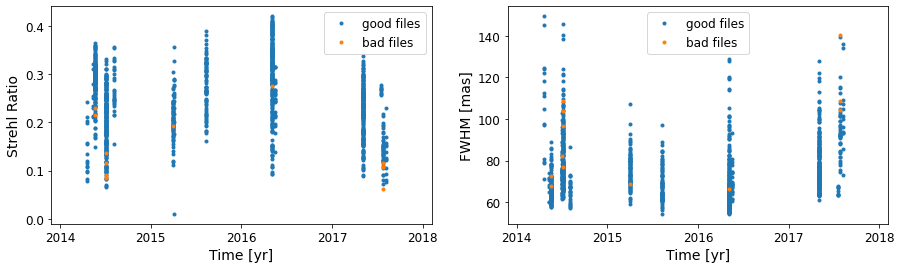

In [44]:
filter_strength = 500
bad_files = data[data.residual_rms_std > filter_strength]
good_files = data[data.residual_rms_std < filter_strength]
# print(f"Bad file percentage: {len(bad_files)/len(data)*100:.2f}%")
# print([file for file in bad_files.telem_file])
for telem_file in good_files.telem_file:
    if '20160517' in telem_file and 'n0058' in telem_file:
        print(telem_file)

fig, ax = plt.subplots(1, 2, figsize=(15,4))
start, end = 2014, 2018.1
years = np.arange(start, end)
xrange = [start-.1, end]

ax[0].plot(good_files.dec_year, good_files.strehl, '.', label='good files')
ax[0].plot(bad_files.dec_year, bad_files.strehl, '.', label='bad files')
ax[0].set_xlim(xrange)
ax[0].set_xticks(years)
ax[0].set_xlabel("Time [yr]")
ax[0].set_ylabel("Strehl Ratio")
ax[0].legend(fontsize=12)

ax[1].plot(good_files.dec_year, good_files.fwhm, '.', label='good files')
ax[1].plot(bad_files.dec_year, bad_files.fwhm, '.', label='bad files')
ax[1].set_xlim(xrange)
ax[1].set_xticks(years)
ax[1].set_xlabel("Time [yr]")
ax[1].set_ylabel("FWHM [mas]")
ax[1].legend(fontsize=12)

plt.show()

In [44]:
# tel_file = "../ao_telemetry/telemetry_table.fits"
# meta_file = "../ao_telemetry/metadata_table.fits"
# df_tele = Table.read(tel_file, format='fits').to_pandas()
# df_meta = Table.read(meta_file, format = 'fits').to_pandas()

In [45]:
### Consolidate data
# df3 = pd.DataFrame()
# df3['rms_err'] = df_meta['rms_err']
# df3['lgrmswf'] = df_meta['lgrmswf']
# df3['residual_rms'] = df_tele['residual_rms']
# df3['residual_rms_std'] = df_tele['residual_rms_std']

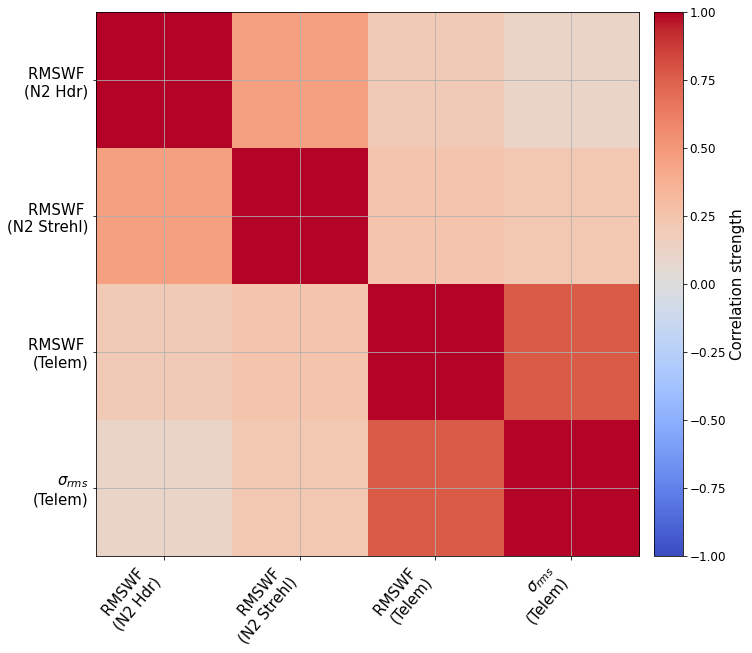

In [46]:
### Correlation matrix
p_util.setup("Results", 'combined')
corr_cols = list(data.columns)
corr_cols.remove('mjd')

settings = p_util.telem_settings
p_util.correlation_matrix(data[corr_cols], settings=settings, fontsize=15, cax=[.91, .125, 0.04, 0.755], save=False, filename="corr.png")

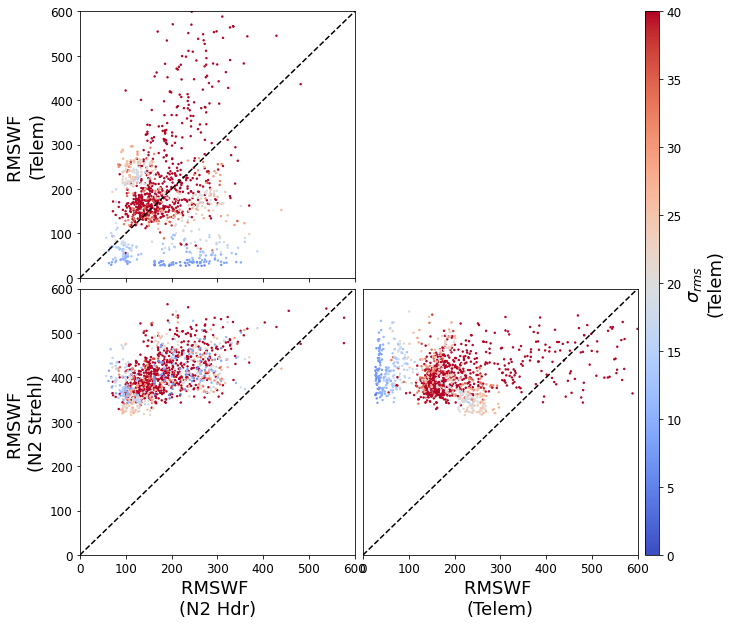

In [47]:
p_util.setup("Results", 'combined')
settings = p_util.telem_settings
# settings['label']['lgrmswf'] = 'RMSWF (NIRC2 Header) [nm]'
labels = ['lgrmswf', 'residual_rms', 'rms_err']
p_util.plot_vars(data, labels, settings=settings, figsize=(10,10), c_var='residual_rms_std', fmt='corner', 
                 fontsize=18, cmap='coolwarm', diag=True, save=True)

#### Weather correlation plot

In [101]:
reload(p_util)

<module 'plot_util' from '/u/emily_ramey/work/Keck_Performance/code/plot_util.py'>

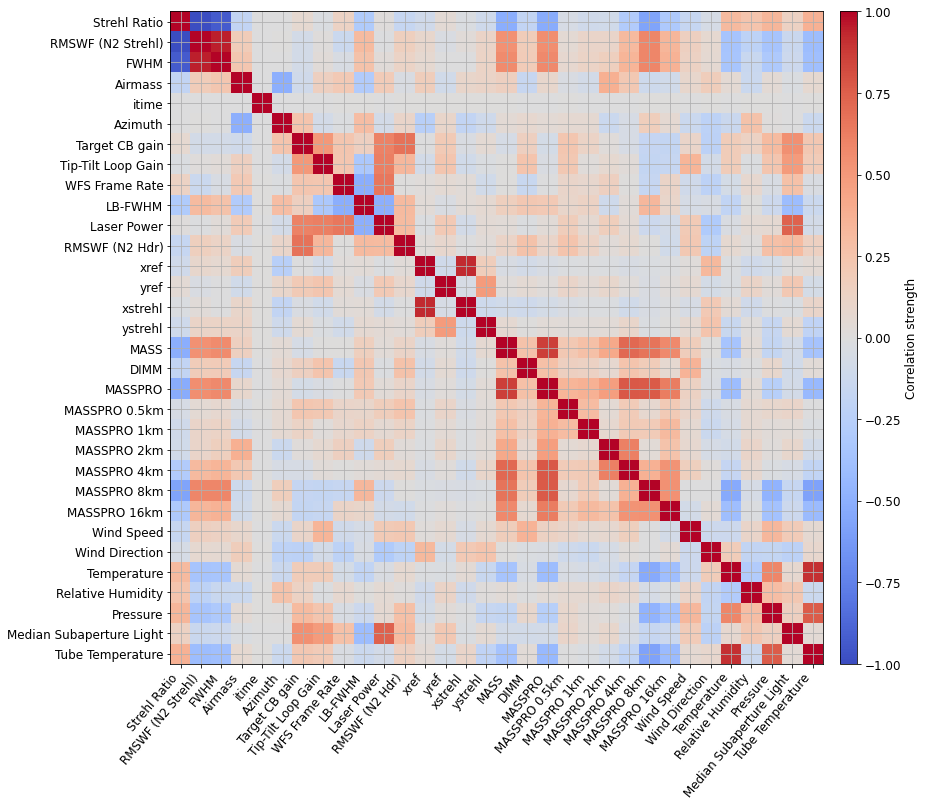

In [102]:
### Plot covariance and correlation plots from Steve's paper
import copy
data = sample3
p_util.setup("Results", 'weather')

corr_vars = ["strehl", "rms_err", "fwhm", "airmass", "itime", "az", "dmgain", "dtgain", "wsfrrt",
          "aolbfwhm", "lsamppwr", "lgrmswf", "xref", "yref", "xstrehl", "ystrehl", "mass", "dimm",
          "masspro", "masspro_half", "masspro_1", "masspro_2", "masspro_4", "masspro_8", "masspro_16",
             "wind_speed", "wind_direction", "temperature", "relative_humidity", "pressure", "aoaoamed", 
             "tubetemp"]

settings = copy.deepcopy(p_util.telem_settings)
for key, val in (p_util.telem_settings['label']).items(): # remove newlines
    settings['label'][key] = val.replace("\n", "")

p_util.correlation_matrix(data, corr_vars, figsize=(12, 12), settings=settings,
                          save=False, filename="corr.png")

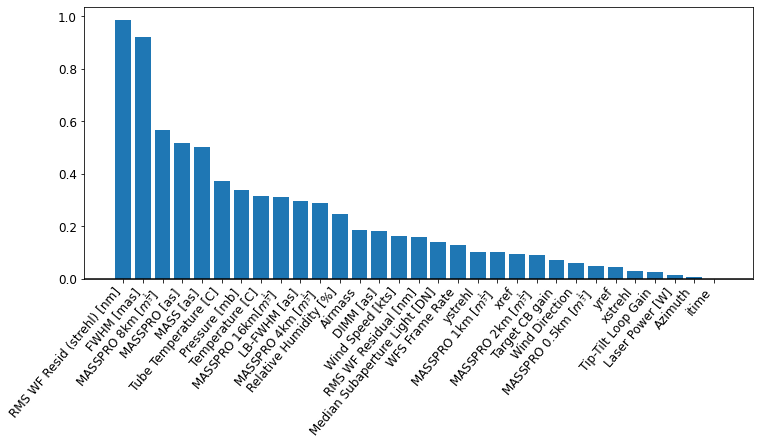

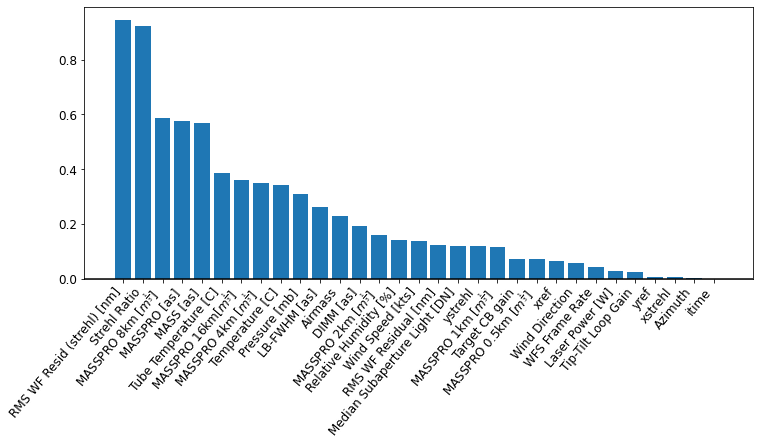

In [103]:
### In 1D form, organized by correlation magnitude:
# Pearson
data = sample3
p_util.correlation_matrix(data, corr_vars, corr_type='pearson', figsize=(12, 5), flatten='strehl', settings=settings,
                          save=False, filename="corr_strehl.png")
p_util.correlation_matrix(data, corr_vars, corr_type='pearson', figsize=(12, 5), flatten='fwhm', settings=settings,
                          save=False, filename="corr_fwhm.png")

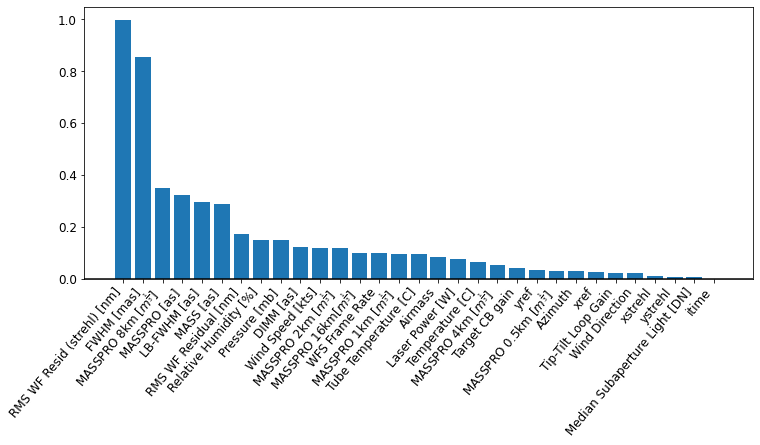

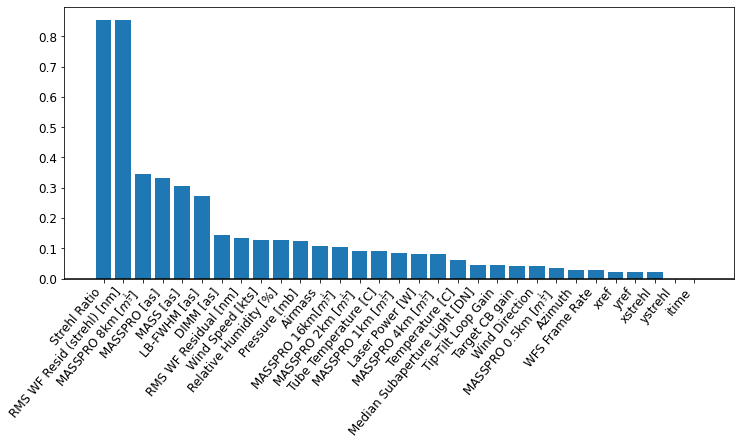

In [104]:
# Kendall
p_util.correlation_matrix(data, corr_vars, corr_type='kendall', figsize=(12, 5), flatten='strehl', settings=settings,
                          save=False, filename="corr_strehl.png")
p_util.correlation_matrix(data, corr_vars, corr_type='kendall', figsize=(12, 5), flatten='fwhm', settings=settings,
                          save=False, filename="corr_fwhm.png")

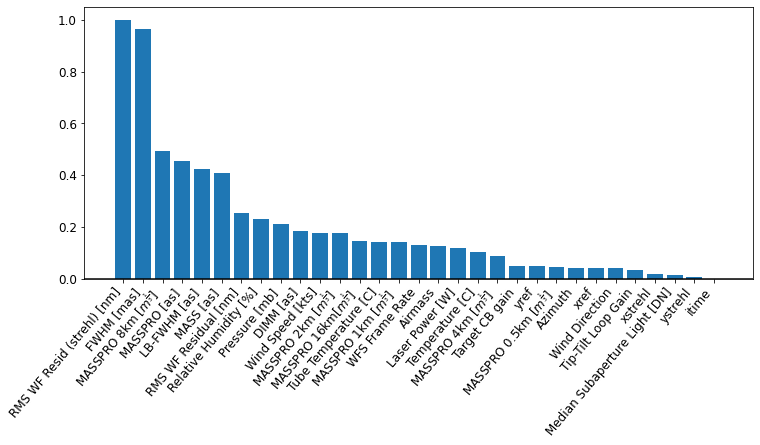

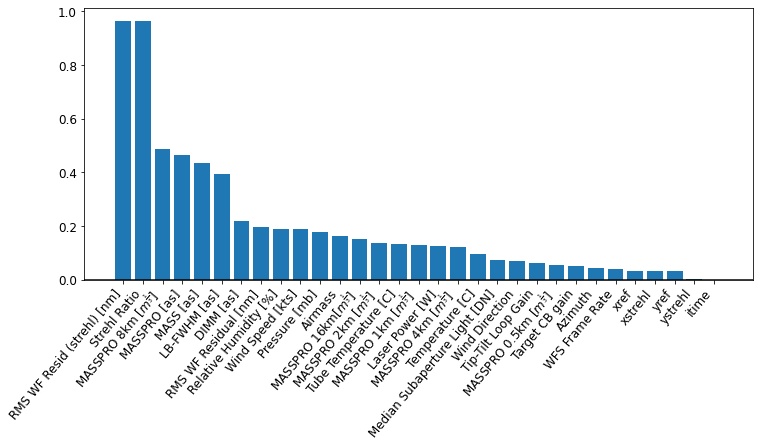

In [105]:
# Spearman
p_util.correlation_matrix(data, corr_vars, corr_type='spearman', figsize=(12, 5), flatten='strehl', settings=settings,
                          save=False, filename="corr_strehl.png")
p_util.correlation_matrix(data, corr_vars, corr_type='spearman', figsize=(12, 5), flatten='fwhm', settings=settings,
                          save=False, filename="corr_fwhm.png")

### ML Results

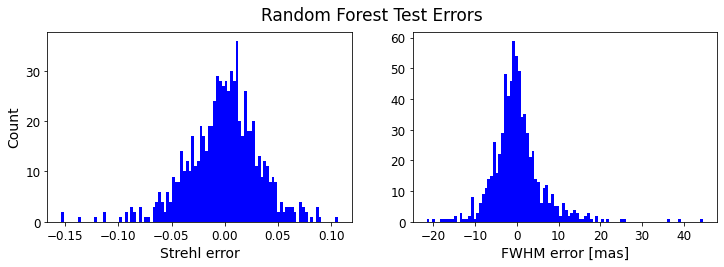

In [38]:
### Random Forest plots
p_util.setup("Results", "ML")
fontsize=14
# Process data
# data = pc.read_file("keck_ML_RF.dat")
data = pc.read_file("keck_clean_woNA.dat")
data.drop(data[data.fwhm > 150].index, inplace=True)
data.reset_index(inplace=True)

data, metrics = ml.run(data, 'RF', False)
train, test = data[data.train==True], data[data.train==False]

# Graph
fig, ax = plt.subplots(1, 2, figsize=[12, 3.5])
# Strehl
ax[0].hist(test.strehl_RF_err, bins=100, color='blue')
ax[0].set_xlabel("Strehl error", fontsize=fontsize)
ax[0].set_ylabel("Count", fontsize=fontsize)
# ax[0].set_ylim(yrange)

# FWHM
ax[1].hist(test.fwhm_RF_err, bins=100, color='blue')
ax[1].set_xlabel("FWHM error [mas]", fontsize=fontsize)
# ax[1].set_ylim(yrange)

plt.suptitle("Random Forest Test Errors", fontsize=fontsize+3)
# p_util.savefig(fig, "rf_test_err_hist.png")
plt.show()

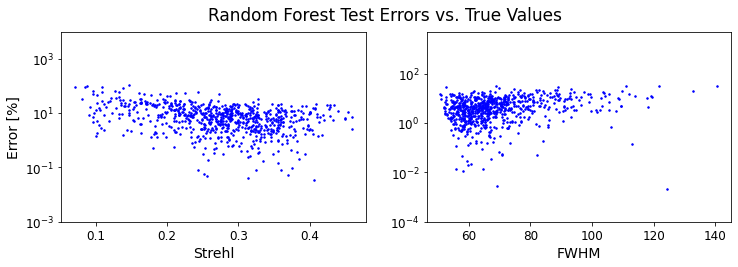

In [39]:
### Percent errors vs. values
p_util.setup("Results", "ML")
fontsize=14
fig, ax = plt.subplots(1, 2, figsize=[12, 3.5])
yrange = [-1, 20]

ax[0].plot(test.strehl, np.abs(100*test.strehl_RF_percent_err), 'b.', ms=3)
ax[0].set_xlabel("Strehl", fontsize=fontsize)
ax[0].set_ylabel("Error [%]", fontsize=fontsize)
ax[0].set_yscale("log")
ax[0].set_ylim([1e-3, 1e4])

ax[1].plot(test.fwhm, np.abs(100*test.fwhm_RF_percent_err), 'b.', ms=3)
ax[1].set_xlabel("FWHM", fontsize=fontsize)
ax[1].set_yscale("log")
ax[1].set_ylim([1e-4, 5e3])
plt.suptitle("Random Forest Test Errors vs. True Values", fontsize=fontsize+3)

# p_util.savefig(fig, "rf_test_errs_vs_vals.png")
plt.show()

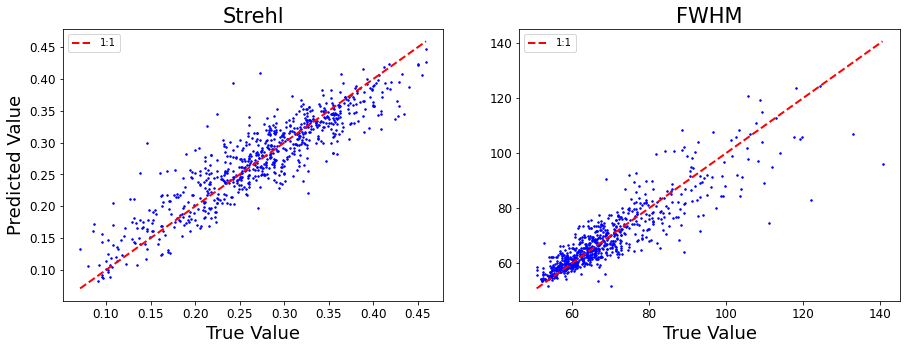

In [40]:
p_util.setup("Results", "ML")
fontsize=18
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(test.strehl, test.strehl_RF_pred, 'b.', ms=3)
s_min, s_max = min(test.strehl), max(test.strehl)
ax[0].plot([s_min, s_max], [s_min, s_max], 'r--', lw=2, label='1:1')
ax[0].set_title("Strehl", fontsize=fontsize+3)
ax[0].set_xlabel("True Value", fontsize=fontsize)
ax[0].set_ylabel("Predicted Value", fontsize=fontsize)
ax[0].legend()

f_min, f_max = min(test.fwhm), max(test.fwhm)
ax[1].plot(test.fwhm, test.fwhm_RF_pred, 'b.', ms=3)
ax[1].plot([f_min, f_max], [f_min, f_max], 'r--', lw=2, label='1:1')
# ax[1].set_xlim([41, 150])
# ax[1].set_ylim([41, 150])
ax[1].set_xlabel("True Value", fontsize=fontsize)
ax[1].set_title("FWHM", fontsize=fontsize+3)
ax[1].legend()

# ax = fig.add_subplot(111, frameon=False)
# ax.set_xlabel("True Value", fontsize=fontsize)
# ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# ax.set_ylabel("Predicted Value", fontsize=fontsize)

plt.show()

In [41]:
metric = 'fwhm'
errs = np.abs(test[metric]-test[metric+'_RF_pred'])
print(f"{metric} MAE: {np.mean(errs)} +/- {np.std(errs)}")
print(f"{metric} MAPE: {np.mean(errs/test[metric])} +/- {np.std(errs/test[metric])}")

fwhm MAE: 4.179662686567163 +/- 4.644323045243577
fwhm MAPE: 0.056873841602208534 +/- 0.05216004461116919


#### Errors in Residual RMS

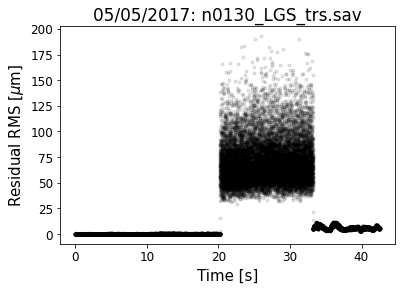

In [37]:
# Different data
p_util.setup("Appendix", "telemetry")
fontsize = 15

testfile3 = "/g/lu/data/keck_telemetry/20170505/sdata904/nirc15/2017may05/n0130_LGS_trs.sav"
data = readsav(testfile3)
res = data.a.residualrms[0][0]
#x = np.linspace(0, len(res)/100, len(res))
x = data.a.timestamp[0]/1e7 # seconds
x -= x[0]

# Plot
fig, ax = plt.subplots()
ax.plot(x, res/100, 'k.', alpha = 0.1, linewidth = 0.5)
ax.set_xlabel('Time [s]', fontsize=fontsize)
ax.set_ylabel(r'Residual RMS [$\mu$m]', fontsize=fontsize)
ax.set_title("05/05/2017: n0130_LGS_trs.sav")

# p_util.savefig(fig, "high_resid_rms_20170505.png")
plt.show()

### Practice: Read all telemetry files

In [43]:
# %load_ext autoreload
# %autoreload 2

In [44]:
import glob
import time
import os
import re
from datetime import datetime
from astropy.time import Time
import keck_data_compiler as comp
# from readsav_copy import readsav

In [45]:
reload(comp)

<module 'keck_data_compiler' from '/u/emily_ramey/work/Keck_Performance/code/keck_data_compiler.py'>

In [46]:
telem_filenames = telem_dir+"**/*.sav"
lgs_filenames = telem_dir+"**/*LGS*.sav"

In [47]:
lgs_rmswf = []
count=0
filenames = glob.glob(lgs_filenames, recursive=True)
# for filename in filenames:
#     data = pd.read_spss()
#     if count==0:
#         lgs_rmswf.append(data.a.residualrms[0])
#     print('.', end='')
#     if count%100==0:
#         print()
#     count+=1

In [48]:
### Read all telemetry files
data = readsav("/g/lu/data/keck_telemetry/20140418/sdata901/nirc5/2014apr18_B/n0034_fullLGS_trs.sav")
# [i for i in range(len(data.header)) if 'MJD-OBS' in str(data.header[i])][0]
np.mean(np.diff(data.a.timestamp[0]))/10 # Microseconds

1333.546863827385

In [49]:
test = data.tstamp_str_start.decode('utf-8')
test

'2014-04-18T14:30:49.09'

In [50]:
fmt = "%Y-%m-%dT%H:%M:%S.%f"
dt = datetime.strptime(test, fmt)

In [51]:
t = Time(dt, format='datetime', scale='utc')

In [52]:
t.mjd

56765.604734837965

In [53]:
nirc2_epoch = "14aprlgs"
nirc2_data = comp.load_nirc2(nirc2_epoch)

Message: NIRC2 file found: /g/lu/data/gc/lgs_data/14aprlgs/clean/kp/


In [54]:
nirc2_data.file

0    c0034.fits
1    c0036.fits
2    c0038.fits
3    c0040.fits
4    c0042.fits
5    c0044.fits
6    c0046.fits
7    c0048.fits
Name: file, dtype: object

In [55]:
pattern = "c(\d+).fits"
m = re.search(pattern, nirc2_data.file[0])
n_fits = None if not m else m[1]
n_fits

'0034'

In [56]:
mjds = Time(nirc2_data.mjd, format='mjd')
mjds = mjds.tt.datetime
telem_datestring = mjds[0].strftime("%Y%m%d")

In [57]:
telem_file = f"/g/lu/data/keck_telemetry/{telem_datestring}/**/n{n_fits}_*.sav"
filename = glob.glob(telem_file, recursive=True)